In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from plotly.offline import init_notebook_mode
import plotly.express as px
import urllib
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud
%matplotlib inline
init_notebook_mode(connected=True)

In [2]:
#main data
customers = pd.read_csv('/kaggle/input/brazilian-ecommerce/olist_customers_dataset.csv')
geolocations = pd.read_csv('/kaggle/input/brazilian-ecommerce/olist_geolocation_dataset.csv')
items = pd.read_csv('/kaggle/input/brazilian-ecommerce/olist_order_items_dataset.csv')
payments = pd.read_csv('/kaggle/input/brazilian-ecommerce/olist_order_payments_dataset.csv')
reviews = pd.read_csv('/kaggle/input/brazilian-ecommerce/olist_order_reviews_dataset.csv')
orders = pd.read_csv('/kaggle/input/brazilian-ecommerce/olist_orders_dataset.csv')
products = pd.read_csv('/kaggle/input/brazilian-ecommerce/olist_products_dataset.csv')
sellers = pd.read_csv('/kaggle/input/brazilian-ecommerce/olist_sellers_dataset.csv')
product_categories = pd.read_csv('/kaggle/input/brazilian-ecommerce/product_category_name_translation.csv')

In [3]:
unique_geolocations = geolocations.drop_duplicates(subset = ['geolocation_zip_code_prefix'])
customers_geolocation = customers.merge(
    unique_geolocations,
    left_on='customer_zip_code_prefix',
    right_on='geolocation_zip_code_prefix',
    how='left'
)

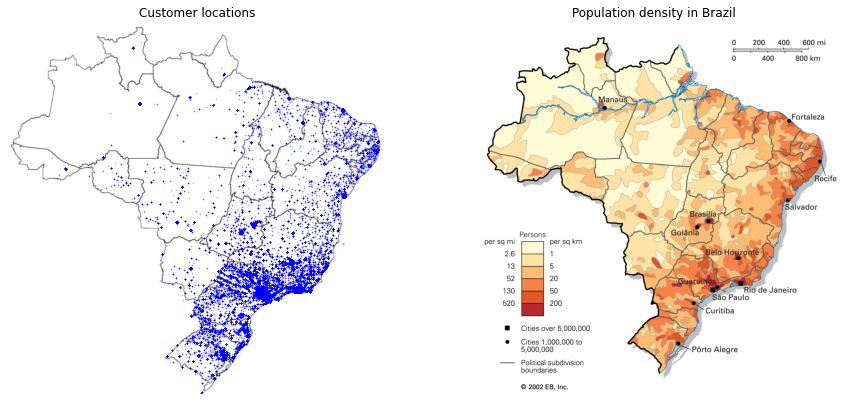

In [4]:
brazil = mpimg.imread(urllib.request.urlopen('https://i.pinimg.com/originals/3a/0c/e1/3a0ce18b3c842748c255bc0aa445ad41.jpg'),'jpg')
brazil_pop = mpimg.imread(urllib.request.urlopen('https://i.pinimg.com/originals/49/6a/9e/496a9eb46b42ea18ec4cc9922ba1cec7.gif'),'gif')
fig, (ax1, ax2) = plt.subplots(1,2)
customers_geolocation.plot(
    kind="scatter",
    x="geolocation_lng",
    y="geolocation_lat",
    ax = ax1,
    figsize=(15,15),
    alpha=0.3,
    s=0.3,
    c='blue'
)
ax1.imshow(brazil, extent=[-73.98283055, -33.8,-33.75116944,5.4])
ax1.axis('off')
ax1.set_title('Customer locations')
ax2.imshow(brazil_pop)
ax2.axis('off')
ax2.set_title('Population density in Brazil')
plt.show()

In [5]:
orders['order_purchase_timestamp'] = pd.to_datetime(orders['order_purchase_timestamp'], format='%Y-%m-%d %H:%M:%S')
orders['order_delivered_customer_date'] = pd.to_datetime(orders['order_delivered_customer_date'], format='%Y-%m-%d %H:%M:%S')
orders['order_estimated_delivery_date'] = pd.to_datetime(orders['order_estimated_delivery_date'], format='%Y-%m-%d %H:%M:%S')

Text(0.5, 1.0, 'Number of Orders over time')

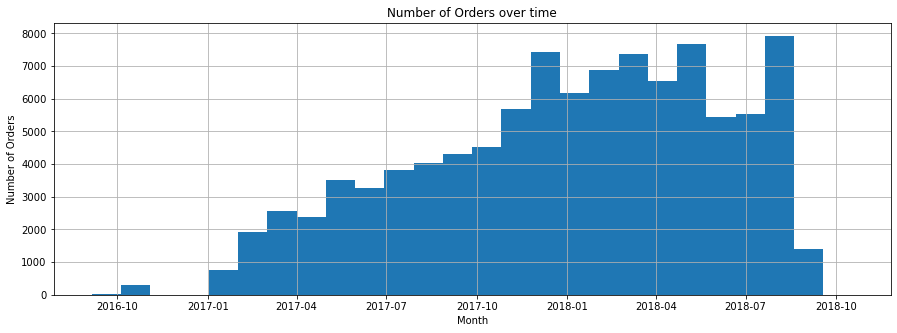

In [6]:
orders['order_purchase_timestamp'].hist(figsize = (15,5), bins = 2*12+10 - 9 + 1)
plt.xlabel('Month')
plt.ylabel('Number of Orders')
plt.title('Number of Orders over time')

In [7]:
print('Average payment is ' + str(payments[['payment_value']].mean().to_numpy()[0]))

Average payment is 154.10038041699553


In [8]:
delivery_time = orders['order_delivered_customer_date'] - orders['order_purchase_timestamp']
est_delivery_time = orders['order_estimated_delivery_date'] - orders['order_purchase_timestamp']
est_real_delivery_time = est_delivery_time - delivery_time

Text(0.5, 1.0, 'Delivery time in days')

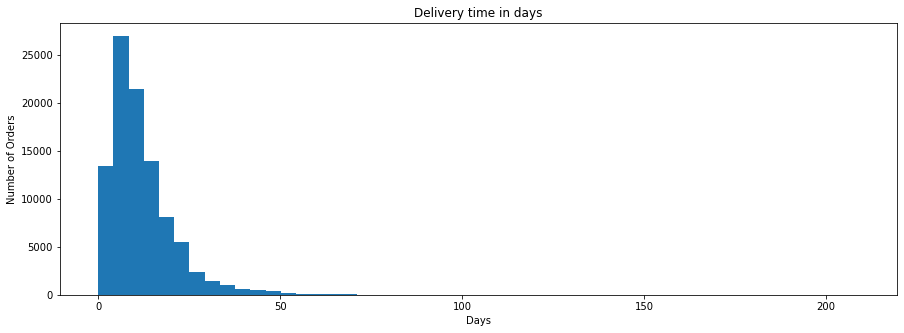

In [9]:
delivery_time.astype('timedelta64[D]').plot.hist(figsize = (15,5), bins = 50)
plt.xlabel('Days')
plt.ylabel('Number of Orders')
plt.title('Delivery time in days')

Text(0.5, 1.0, 'Estimated delivery time in days')

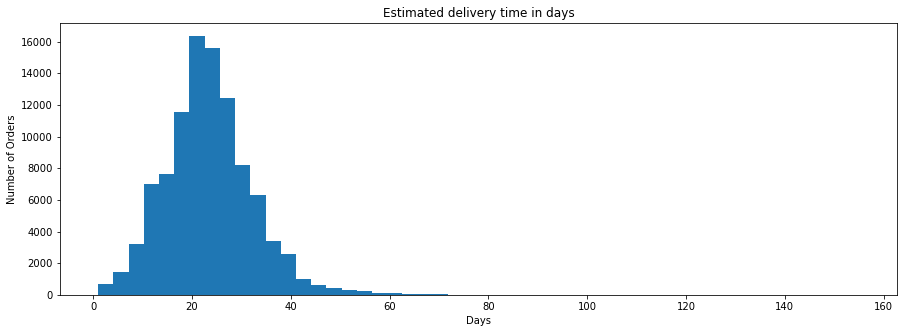

In [10]:
est_delivery_time.astype('timedelta64[D]').plot.hist(figsize = (15,5), bins = 50)
plt.xlabel('Days')
plt.ylabel('Number of Orders')
plt.title('Estimated delivery time in days')

Text(0.5, 1.0, 'Difference between estimated and actual delivery time in days')

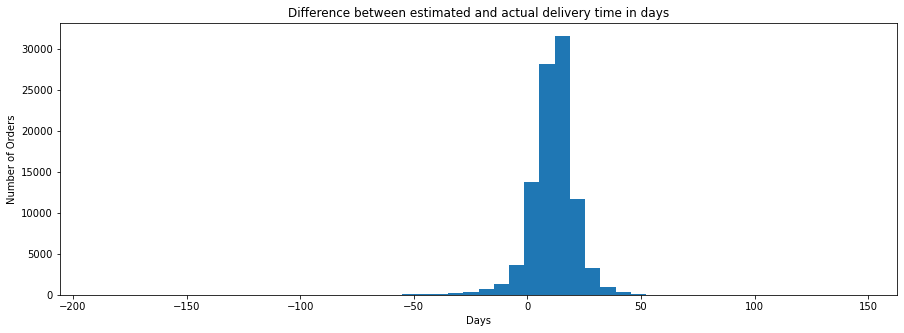

In [11]:
est_real_delivery_time.astype('timedelta64[D]').plot.hist(figsize = (15,5), bins = 50)
plt.xlabel('Days')
plt.ylabel('Number of Orders')
plt.title('Difference between estimated and actual delivery time in days')

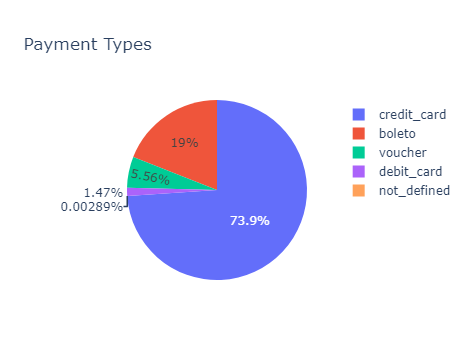

In [12]:
px.pie(
    payments.
        groupby('payment_type', as_index = False).
        size().
        rename(columns = {'payment_type': 'Payment Type', 'size': 'Number of Orders'}),
    values='Number of Orders',
    names='Payment Type',
    title='Payment Types'
)

Text(0.5, 1.0, 'Ratings')

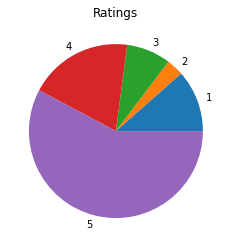

In [13]:
reviews.groupby('review_score').size().plot(kind = 'pie')
plt.xlabel('')
plt.ylabel('')
plt.title('Ratings')

Text(0.5, 1.0, 'Orders on different weekdays')

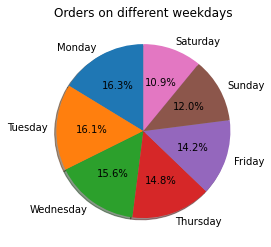

In [14]:
order_weekdays = (orders['order_purchase_timestamp'].
    apply(lambda x: x.strftime('%A')).
    value_counts())
plt.pie(
    order_weekdays,
    labels=order_weekdays.index,
    autopct='%1.1f%%',
    shadow=True,
    startangle=90
)
plt.title('Orders on different weekdays')

In [15]:
print('How many times did a customer order?')
customer_unique_ids = customers[['customer_unique_id']].to_numpy().flatten()
unique, counts = np.unique(customer_unique_ids, return_counts = True)
customer_unique_ids_counts = dict(zip(unique, counts))
count, count_of_counts = np.unique(counts, return_counts = True)
multiple_orders = dict(zip(count, count_of_counts))
multiple_orders

How many times did a customer order?


{1: 93099, 2: 2745, 3: 203, 4: 30, 5: 8, 6: 6, 7: 3, 9: 1, 17: 1}

Text(0.5, 1.0, 'How many times did a customer order?')

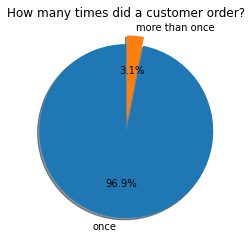

In [16]:
labels = 'once', 'more than once'
sizes = multiple_orders[1], sum(multiple_orders.values()) - multiple_orders[1]
explode = (0,0.1)
plt.pie(
    sizes,
    explode=explode,
    labels=labels,
    autopct='%1.1f%%',
    shadow=True,
    startangle=90
)
plt.title('How many times did a customer order?')

In [17]:
ordered_products = orders.merge(
    # get product id
    items,
    left_on = 'order_id',
    right_on = 'order_id',
    how = 'inner'
).merge(
    # get product category name in portugese
    products,
    left_on='product_id',
    right_on='product_id',
    how='inner'
).merge(
    # get product category name in english
    product_categories,
    left_on='product_category_name',
    right_on='product_category_name',
    how='inner'
)

Text(0.5, 1.0, 'Ordered quantities for 10 most commonly ordered product categories')

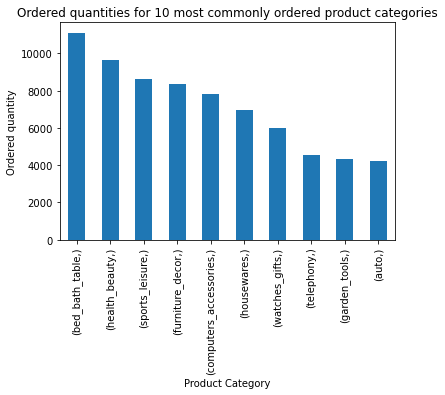

In [18]:
common_products = ordered_products[['product_category_name_english']].value_counts()[:10].plot.bar()
common_products.set_xlabel('Product Category')
common_products.set_ylabel('Ordered quantity')
common_products.set_title('Ordered quantities for 10 most commonly ordered product categories')

Text(0.5, 1.0, 'Ordered quantities for 10 least commonly ordered product categories')

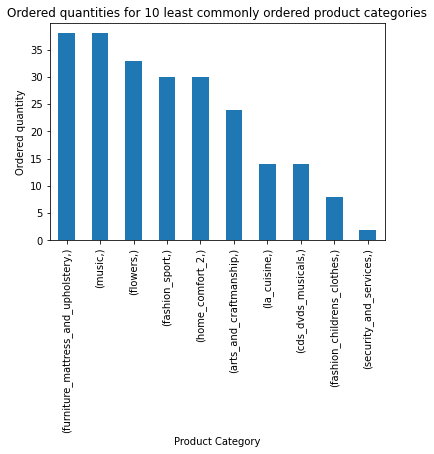

In [19]:
rare_products = ordered_products[['product_category_name_english']].value_counts()[-10:].plot.bar()
rare_products.set_xlabel('Product Category')
rare_products.set_ylabel('Ordered quantity')
rare_products.set_title('Ordered quantities for 10 least commonly ordered product categories')

In [20]:
bad_reviews = reviews[reviews['review_score'] == 1]['review_comment_message'].dropna()

In [21]:
bad_reviews

19                                                 Péssimo
29                     Não gostei ! Comprei gato por lebre
32       Sempre compro pela Internet e a entrega ocorre...
39                            Nada de chegar o meu pedido.
51       recebi somente 1 controle Midea Split ESTILO.\...
                               ...                        
99094    Gostaria de saber porque meu produto ainda não...
99141    Ate hoje dia 21/10/2017 o pedido não foi entre...
99155    Eu recebi o seguinte email e preciso saber com...
99169    Boa tarde. \r\nNão recebo todos os produtos fa...
99223    meu produto chegou e ja tenho que devolver, po...
Name: review_comment_message, Length: 8745, dtype: object

In [1]:
nltk.download('stopwords')
stop_words = stopwords.words('portuguese')
wordcloud = WordCloud(
    stopwords=stop_words,
    background_color="black",
    width=1600,
    height=800
).generate(' '.join(bad_reviews))
fig, ax = plt.subplots(figsize=(10,6))
ax.imshow(wordcloud, interpolation='bilinear')
ax.set_axis_off()
plt.imshow(wordcloud)

NameError: name 'nltk' is not defined